In [ ]:
#Predicting the next 10 days

In [30]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math

from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
# Load the data into a Pandas DataFrame
bt = pd.read_csv(
    "crypto project/Bitcoin Historical Data (2014-2024).csv")

# Display sample data
bt.head(10)



,Date,Price,Open,High,Low,Vol.,Change %
0,03/24/2024,"67,211.9","64,036.5","67,587.8","63,812.9",65.59K,4.96%
1,03/23/2024,"64,037.8","63,785.6","65,972.4","63,074.9",35.11K,0.40%
2,03/22/2024,"63,785.5","65,501.5","66,633.3","62,328.3",72.43K,-2.62%
3,03/21/2024,"65,503.8","67,860.0","68,161.7","64,616.1",75.26K,-3.46%
4,03/20/2024,"67,854.0","62,046.8","68,029.5","60,850.9",133.53K,9.35%
5,03/19/2024,"62,050.0","67,594.1","68,099.6","61,560.6",148.08K,-8.20%
6,03/18/2024,"67,594.1","68,389.7","68,920.1","66,601.4",78.07K,-1.17%
7,03/17/2024,"68,391.2","65,314.2","68,857.7","64,605.5",66.07K,4.71%
8,03/16/2024,"65,314.2","69,456.5","70,037.0","64,971.0",75.82K,-5.97%
9,03/15/2024,"69,463.7","71,387.1","72,398.1","65,765.6",148.59K,-2.69%


In [4]:
# Convert the date column to datetime format if it's not already in datetime
bt['Date'] = pd.to_datetime(bt['Date'], format='%m/%d/%Y')

# Sort the DataFrame by the 'Date' column in ascending order
bt = bt.sort_values(by='Date', ascending=True)

# Print the sorted DataFrame
print(bt)

           Date     Price      Open      High       Low     Vol. Change %
3653 2014-03-24     567.6     551.2     572.5     531.3    3.67K    2.98%
3652 2014-03-25     562.9     567.6     569.7     550.4    3.87K   -0.82%
3651 2014-03-26     562.5     562.9     575.4     546.3    3.71K   -0.08%
3650 2014-03-27     460.5     562.5     567.8     460.5    3.78K  -18.13%
3649 2014-03-28     482.6     460.5     515.0     453.8    4.11K    4.81%
...         ...       ...       ...       ...       ...      ...      ...
4    2024-03-20  67,854.0  62,046.8  68,029.5  60,850.9  133.53K    9.35%
3    2024-03-21  65,503.8  67,860.0  68,161.7  64,616.1   75.26K   -3.46%
2    2024-03-22  63,785.5  65,501.5  66,633.3  62,328.3   72.43K   -2.62%
1    2024-03-23  64,037.8  63,785.6  65,972.4  63,074.9   35.11K    0.40%
0    2024-03-24  67,211.9  64,036.5  67,587.8  63,812.9   65.59K    4.96%

[3654 rows x 7 columns]


In [5]:
#Columns information
bt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3654 entries, 3653 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3654 non-null   datetime64[ns]
 1   Price     3654 non-null   object        
 2   Open      3654 non-null   object        
 3   High      3654 non-null   object        
 4   Low       3654 non-null   object        
 5   Vol.      3654 non-null   object        
 6   Change %  3654 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 228.4+ KB


In [6]:
# How many samples do we have?
len(bt)

3654

In [7]:
#Column type change 
bt[["Price"]] = bt[["Price"]].applymap(lambda x: float(x.replace(',', '')))

C:\Users\rtkam\AppData\Local\Temp\ipykernel_32016\2567909763.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  bt[["Price"]] = bt[["Price"]].applymap(lambda x: float(x.replace(',', '')))


In [8]:
# Only want Price column for each day 

bitcoin_prices = bt.reset_index()['Price']
bitcoin_prices.head()


0    567.6
1    562.9
2    562.5
3    460.5
4    482.6
Name: Price, dtype: float64

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
bitcoin_prices = scaler.fit_transform(np.array(bitcoin_prices).reshape(-1,1))

In [10]:
bitcoin_prices

array([[0.0055239 ],
       [0.00545943],
       [0.00545394],
       ...,
       [0.8726938 ],
       [0.87615464],
       [0.91969427]])

In [11]:
#Splitting the data set into train and test split
training_size = int(len(bitcoin_prices)*0.7)
test_size = len(bitcoin_prices)- training_size

train_data, test_data = bitcoin_prices[0:training_size,:], bitcoin_prices[training_size:len(bitcoin_prices),:1]


In [12]:
training_size, test_size

(2557, 1097)

In [13]:
#Convert an array of values into a dataset matris

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range (len(dataset) - time_step -1):
        a = dataset[i:(i + time_step), 0] #i=0, 0, 1, 2, 3
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [14]:
#reshape into X=t, t+1, t+2, t+3 and y=t+4
time_step = 100
X_train, y_train= create_dataset(train_data, time_step)
X_test, y_test= create_dataset(test_data, time_step)

In [15]:
print(X_train.shape), print(y_train.shape)

(2456, 100)
(2456,)


(None, None)

In [16]:
#Reshape the data to be samples, time steps, features whisch is required for LSTM
X_train= X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [17]:
#Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences= True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences= True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


c:\Users\rtkam\anaconda3\envs\dev\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 4.1498e-04 - val_loss: 0.0025
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4.2545e-04 - val_loss: 0.0054
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 4.9352e-04 - val_loss: 0.0030
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.5556e-04 - val_loss: 0.0020
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 3.0414e-04 - val_loss: 0.0054
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.9857e-04 - val_loss: 0.0018
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.8730e-04 - val_loss: 0.0031
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.5192e-04 - val_loss: 0.0020
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.8203e-04 - val_loss: 0.0016
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.9760e-04 - val_loss: 0.0017
Epoch 12/100

In [20]:
#Do the prediction and check performande metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [21]:
#Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [22]:
#Calculate the RMSE performance metrics for the train data
math.sqrt(mean_squared_error(y_train, train_predict))

10631.587106744577

In [23]:
#Calculate the RMSE performance metrics for the test data
math.sqrt(mean_squared_error(y_test, test_predict))

37354.908717650294

In [24]:
#Plotting
#Chnge train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(bitcoin_prices)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

In [25]:
#Change test predictions for plotting
testPredictPlot = np.empty_like(bitcoin_prices)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back *2) + 1: len(bitcoin_prices) -1, :] = test_predict

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


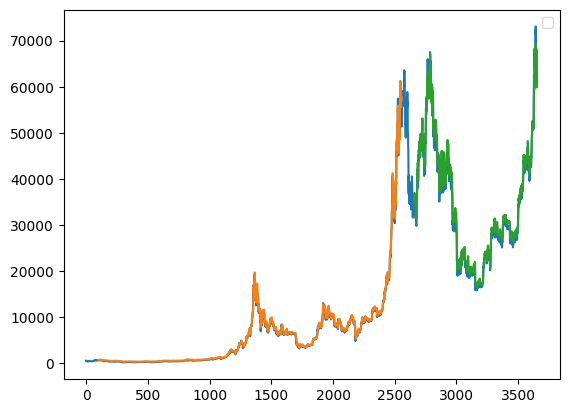

In [26]:
#Plot baseline and predictions

plt.plot(scaler.inverse_transform(bitcoin_prices))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

In [27]:
#Looking the len of the test data because we will use only the last 100 rows to predict the next 10 days
len(test_data)

1097

In [29]:
#Having only the 100 rows we need
X_input= test_data[997:].reshape(1,-1)
X_input.shape

(1, 100)

In [31]:
#Convert into a list
temp_input= list(X_input)
temp_input=temp_input[0].tolist()

In [33]:
#Prediction for the next 10 days
lst_output= []
n_steps=100
i=0
while(i<10):

    if(len(temp_input)>100):
        X_input=np.array(temp_input[1:])
        print("{} day input {}".format(i, X_input))
        X_input=X_input.reshape(1,-1)
        X_input= X_input.reshape((1, n_steps, 1))

        yhat= model.predict(X_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i= i+1
    else:
        X_input= X_input.reshape((1, n_steps, 1))
        yhat= model.predict(X_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i= i+1

        print(lst_output)


0 day input [0.58086402 0.58957167 0.58440304 0.56415652 0.56903022 0.56968042
 0.56814135 0.54033942 0.544899   0.54760402 0.54554234 0.57127024
 0.57551707 0.57427978 0.59168823 0.58683784 0.58182147 0.5886924
 0.59024655 0.58765401 0.58183382 0.58342227 0.58877882 0.60595407
 0.61903338 0.64419339 0.6528448  0.65996538 0.68279073 0.67970025
 0.70804539 0.70967636 0.71287108 0.70617437 0.71264201 0.70806185
 0.71464471 0.70908515 0.70170806 0.69375348 0.70515381 0.70722647
 0.74525592 0.78038693 0.85461596 0.83680697 0.85365713 0.84812637
 0.86378177 0.93420977 0.87279119 0.90417331 0.91480273 0.93286412
 0.9355321  0.94373908 0.98673277 0.97810604 1.         0.97697164
 0.95058257 0.89366322 0.93587092 0.92493697 0.84888768 0.92850206
 0.89626399 0.8726938  0.87615464 0.91969427 0.91045195 0.88814068
 0.87221247 0.86049467 0.85538036 0.85536778 0.85804379 0.86134094
 0.86408162 0.86594087 0.86712843 0.86802179 0.86890262 0.86984903
 0.8707639  0.87146729 0.87179232 0.87164617 0.8710

In [34]:
new_day = np.arange(1,101)
pred_day = np.arange(101, 111)

In [35]:
len(bitcoin_prices)

3654

In [36]:
#Adding the prediction 
btc_data=bitcoin_prices.tolist()
btc_data.extend(lst_output)

In [37]:
len(btc_data)

3664

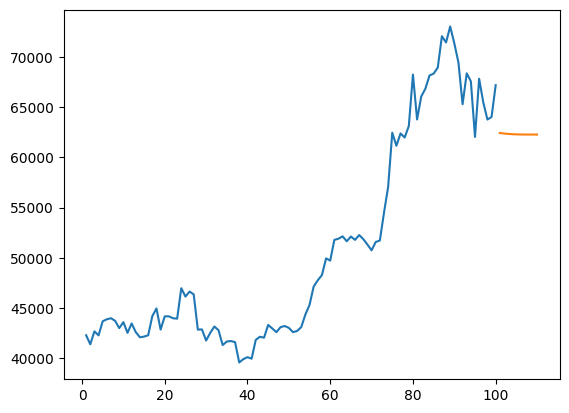

In [38]:
plt.plot(new_day, scaler.inverse_transform(bitcoin_prices[3554:]))
plt.plot(pred_day, scaler.inverse_transform(lst_output))

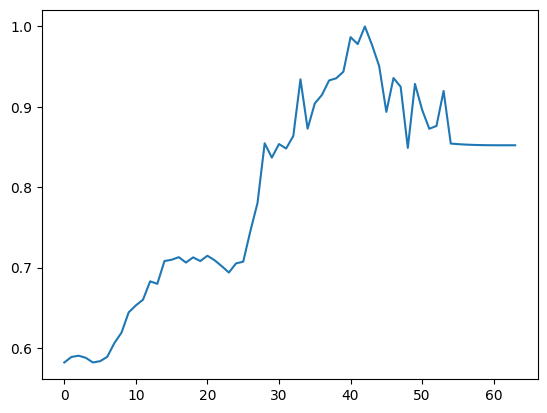

In [44]:
plt.plot(btc_data[3600:])